In [73]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import pandas as pd
import datetime as dt
import cython
%load_ext Cython



The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Kalman filter

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$




Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances (?)

In [74]:
class KalmanFilter():
    #     """
    #         Based on Durbin Koopman


    #         For generic state-space systems like (Hamilton's notation):



    #         $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

    #         $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
    #         \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


    #         $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

    #         Where

    #         * $p$ is the number of observed variables
    #         * $m$ is the number of latent states
    #         * $r$ is the number of disturbances

    #     """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)

    def runFilter(self, ):
        # Implemented with non time varying coefficients

        for i in range(0, self.n - 1):
            #         for i in range(0,1):
            #             print(self.y[i].shape)
            #             print(self.Z.shape)
            #             print(self.a[i].shape)

            self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

            self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

            Finv = inv(self.Ft[i])

            #             print(self.P[i].shape)
            #             print(self.ZT.shape)
            #             print(Finv.shape)
            #             print(self.vt[i].shape)
            self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

            self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

            self.a.append(self.T.dot(self.a[i]))

            self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

            self.yhat.append(self.Z.dot(self.a[i]))

        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

# Pandas or numpy dot product ?

In [75]:
df = {
    dt.datetime(2017,1,1) : np.random.randn(4),
    dt.datetime(2017,1,2) : np.random.randn(4),
    dt.datetime(2017,1,3) : np.random.randn(4),
    dt.datetime(2017,1,4) : np.random.randn(4),
}

In [76]:
df = pd.DataFrame(df).T
df

,0,1,2,3
2017-01-01,0.355875,-0.179892,0.435321,0.246049
2017-01-02,1.754386,-0.455626,0.604726,1.466554
2017-01-03,-0.543262,1.193084,-1.259483,-0.670817
2017-01-04,-1.943084,-0.695628,-1.002274,0.566895


In [77]:
dfnp = np.array(df)
dfnp

array([[ 0.35587474, -0.17989165,  0.43532073,  0.24604917],
       [ 1.75438614, -0.45562612,  0.60472554,  1.46655393],
       [-0.54326224,  1.19308414, -1.25948324, -0.67081664],
       [-1.94308385, -0.69562836, -1.00227379,  0.5668948 ]])

In [78]:
%%timeit -n 10000

df.dot(df.T)


10000 loops, best of 3: 262 µs per loop


In [79]:
%%timeit -n 10000

np.dot(dfnp,dfnp.T)

10000 loops, best of 3: 1.55 µs per loop


Numpy as WAY faster

# Numpy or python append?

Which one is faster to append new values and access the last one

In [80]:
lis = [1.756756,2.123123,3.24234]
nplis = np.array(lis)

In [81]:
%%timeit -n 10000

lis.append(7.21342)

lis[-1] + 3.46785

10000 loops, best of 3: 133 ns per loop


In [82]:
%%timeit -n 10000
np.append(nplis,7)
nplis[-1] + 3.46785

10000 loops, best of 3: 5.27 µs per loop


Python append is way faster

# Dummy data for the KF with non time-varying parameters

For convenience: 

$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

## Local Level model

$$ y_t = \mu_t + \epsilon_t, \qquad \epsilon \sim NID(0, \sigma^2_ \epsilon) $$
$$ \mu_{t+1} = \mu_t + \eta_t, \qquad \eta_t \sim NID(0,\sigma^2_ \eta) $$

In [83]:
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1,2,3,4]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

In [84]:
n = 1000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)

In [85]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

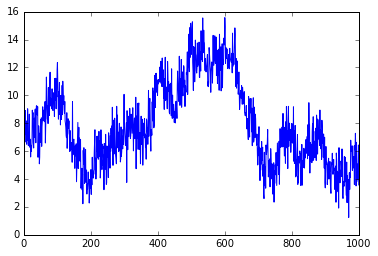

In [86]:
y[0].plot()

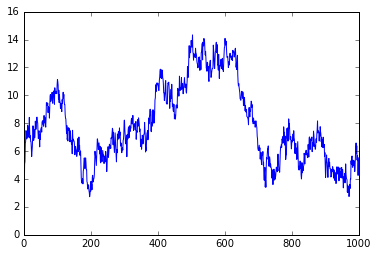

In [87]:
kf.yhat[0].plot()

## Timing the filter with and without Cython

In [88]:
# %%timeit -n 50
# kf = KalmanFilter(y,
#                   Z,
#                   H,
#                   T,
#                   Q,
#                   pd.DataFrame(np.array([0,0]).reshape(m,1)),
#                   pd.DataFrame(np.diag(np.array([1,1]))),
#                   R)

# kf.runFilter()

In [89]:
# import pyximport; pyximport.install()
# import KalmanFilter1

In [90]:
# %%timeit -n 50
# # COMPILED WITH CYTHON

# kf = KalmanFilter1.KalmanFilter(y,
#                   Z,
#                   H,
#                   T,
#                   Q,
#                   pd.DataFrame(np.array([0,0]).reshape(m,1)),
#                   pd.DataFrame(np.diag(np.array([1,1]))),
#                   R)

# kf.runFilter()

# Implementation for nulls

## Faster way to check for nulls Pandas or Numpy

In [91]:
ynp = np.array(y)

In [92]:
%%timeit -n 1000
y.isnull().any(axis=1)

1000 loops, best of 3: 258 µs per loop


In [93]:
%%timeit -n 1000
np.isnan(ynp).any(axis=1)

1000 loops, best of 3: 5.26 µs per loop


In [94]:
%%timeit -n 1000
y.isnull().all(axis=1)

1000 loops, best of 3: 244 µs per loop


In [95]:
%%timeit -n 1000
np.isnan(ynp).all(axis=1)

1000 loops, best of 3: 5.56 µs per loop


## Timing Implemention for whole line of nulls

In [108]:
class KalmanFilter():
#         """
#             Based on Durbin Koopman


#             For generic state-space systems like (Hamilton's notation):



#             $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

#             $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
#             \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


#             $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

#             Where

#             * $p$ is the number of observed variables
#             * $m$ is the number of latent states
#             * $r$ is the number of disturbances

#         """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
  
        
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        
        ind = np.zeros(self.y.shape[0])
        ind[np.isnan(self.y).any(axis=1)] = 1 # Some NaNs
        ind[np.isnan(self.y).all(axis=1)] = 2 # All NaNs
        self.ind = ind  
        
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)
        

    def runFilter(self, ):
        # Implemented with non time varying coefficients
        
        for i in range(0, self.n - 1):
            print(i)
            if self.ind[i] == 0:

                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))
            
            elif self.ind[i] == 2: # In case the line is all nans
            
                self.vt.append(np.zeros((p,1)))
#                 self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

#                 Finv = inv(self.Ft[i])

#                 self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

#                 self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))
                
                self.yhat.append(self.Z.dot(self.a[i]))  
            
        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = 
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

In [109]:
y[20] = np.nan

In [110]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ValueError: need at least one array to concatenate

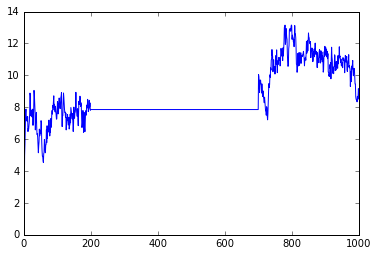

In [42]:
kf.yhat[0].plot()

In [29]:
kf = KalmanFilter(ny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

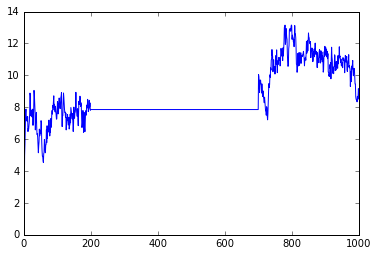

In [30]:
kf.yhat[0].plot()

In [68]:
%%timeit -n 50

kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

ValueError: need at least one array to concatenate

In [28]:
# with many nulls
ny = y.copy()
ny.iloc[200:700] = np.nan

In [107]:
%%timeit -n 50

kf = KalmanFilter(ny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

50 loops, best of 3: 100 ms per loop


## Timing Implemention for partial line of nulls

### Fastest way to flat out 

In [31]:
yt = np.array([1,2,4,np.nan,5,6,7,np.nan,np.nan,8]).reshape((10,1))

In [32]:
yt[~np.isnan(yt)]

array([ 1.,  2.,  4.,  5.,  6.,  7.,  8.])

In [33]:
%%timeit -n 1000

~np.isnan(yt).reshape((10))

1000 loops, best of 3: 2.09 µs per loop


In [34]:
%%timeit -n 1000

np.array((~np.isnan(yt)).flat)

1000 loops, best of 3: 4.68 µs per loop


In [35]:
%%timeit -n 1000

(~np.isnan(yt)).ravel()

1000 loops, best of 3: 1.42 µs per loop


In [36]:
%%timeit -n 1000

(~np.isnan(yt)).flatten()

1000 loops, best of 3: 1.89 µs per loop


In [37]:
class KalmanFilter():
#         """
#             Based on Durbin Koopman


#             For generic state-space systems like (Hamilton's notation):



#             $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

#             $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
#             \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


#             $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

#             Where

#             * $p$ is the number of observed variables
#             * $m$ is the number of latent states
#             * $r$ is the number of disturbances

#         """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
  
        
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        
        ind = np.zeros(self.y.shape[0])
        ind[np.isnan(self.y).any(axis=1)] = 1 # Some NaNs
        ind[np.isnan(self.y).all(axis=1)] = 2 # All NaNs
        self.ind = ind  
        
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)
        

    def runFilter(self, ):
        # Implemented with non time varying coefficients
        
        for i in range(0, self.n - 1):
            
            if self.ind[i] == 0:

                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))
            
            elif self.ind[i] == 2: # In case the line is all nans
            
                self.vt.append(np.zeros((p,1)))
#                 self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

#                 Finv = inv(self.Ft[i])

#                 self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

#                 self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))  
            
            else:
                # First use an index for nulls
                ind = ~np.isnan(self.y[i]).ravel()
                yst = self.y[i][ind]
                Zst = self.Z[ind,:]
                
                select = np.diag(ind)
                select = select[(select==True).any(axis=1)].astype(int)

                Hst = select.dot(self.H).dot(select.T)
                
                
                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(Zst, self.a[i]))

                self.Ft.append(Zst.dot(self.P[i]).dot(Zst) + Hst)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(Zst).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(Zst).dot(Finv).dot(Zst).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))
                
                yhat = np.empty((p,1))
                yhat[ind,:] = Zst.dot(self.a[i])
                yhat[~ind,:] = self.Z.dot(self.a[i])[~ind,:]
                
                self.yhat.append(yhat)
                
                
            
        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

In [38]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

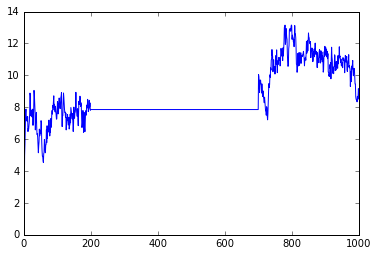

In [40]:
kf.yhat[0].plot()